In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import seaborn as sns
import spacy
from spacy.language import Language
from spacy_language_detection import LanguageDetector

from data_loader import (
    get_users_df,
    get_reviews_df,
    get_beers_df,
    get_breweries_df,
    join_breweries_on_beers,
    merge_reviews,
)

In [3]:
reviews_path_ba = "data/matched_beer_data/ratings_ba.txt"
reviews_path_rb = "data/matched_beer_data/ratings_rb.txt"
users_path_ba = "data/users_ba.csv"
users_path_rb = "data/users_rb.csv"
breweries_path = "data/matched_beer_data/breweries.csv"
beers_path = "data/matched_beer_data/beers.csv"

In [68]:
states_climate = pd.read_csv("data/states_climate.csv")
states_climate.set_index("State", inplace=True)

# Seeing the world through the lens of beer reviews


Beers are produced and consumed in every part of the world. One can thus wonder how beers around the world are perceived by different cultures. The interest of this project is to look into how beers from each country of production are judged and how specific countries judge others. As a side note, we will finally answer an age-old question : Are German beers actually good ?

On the one hand, we want to explore how a country’s beers are perceived both quantitatively and qualitatively. On the other hand, we will analyze the users’ ratings and look for significant patterns in how distinct countries rate other countries. For both of these analyses, we will dissect both the ratings and reviews to understand the feelings of the users. These findings will also be mapped to their climate to see if there is a correlation between a countries’ beer rating and the climate of said country. 


## 1) Loading data 

- All the pre-processing is done using the functions defined in `data_loader.py`.
- The preprocessing functions are described and documented in `data_loader.py`.
- We use the reviews/ ratings from both BeerAdvocate and RateBeer, and use the matched beers and breweries dataset to make sure that the names of the same beers are identical across the two datasets.
- Those two reviews/ ratings datasets are then merged and joined to the breweries, beers and users datasets to obtain a single complete dataframe of beer reviews.



In [5]:
users_df_ba = get_users_df(users_path_ba)
users_df_rb = get_users_df(users_path_rb)
ba_df = get_reviews_df(reviews_path_ba)
rb_df = get_reviews_df(reviews_path_rb)
breweries_df = get_breweries_df(breweries_path)
beers_df = get_beers_df(beers_path)
beers_df = join_breweries_on_beers(beers_df, breweries_df)
reviews_df = merge_reviews(ba_df, rb_df, beers_df, users_df_ba, users_df_rb)

## Is focusing on the US a feasible idea ?

### Numerical reviews

Here we want only the revieys of users in the US and then drop the beers with less than 10 reviews and see how many reviews per state there is after it.

 Percentage of ratings left:  97.43390674692388 %


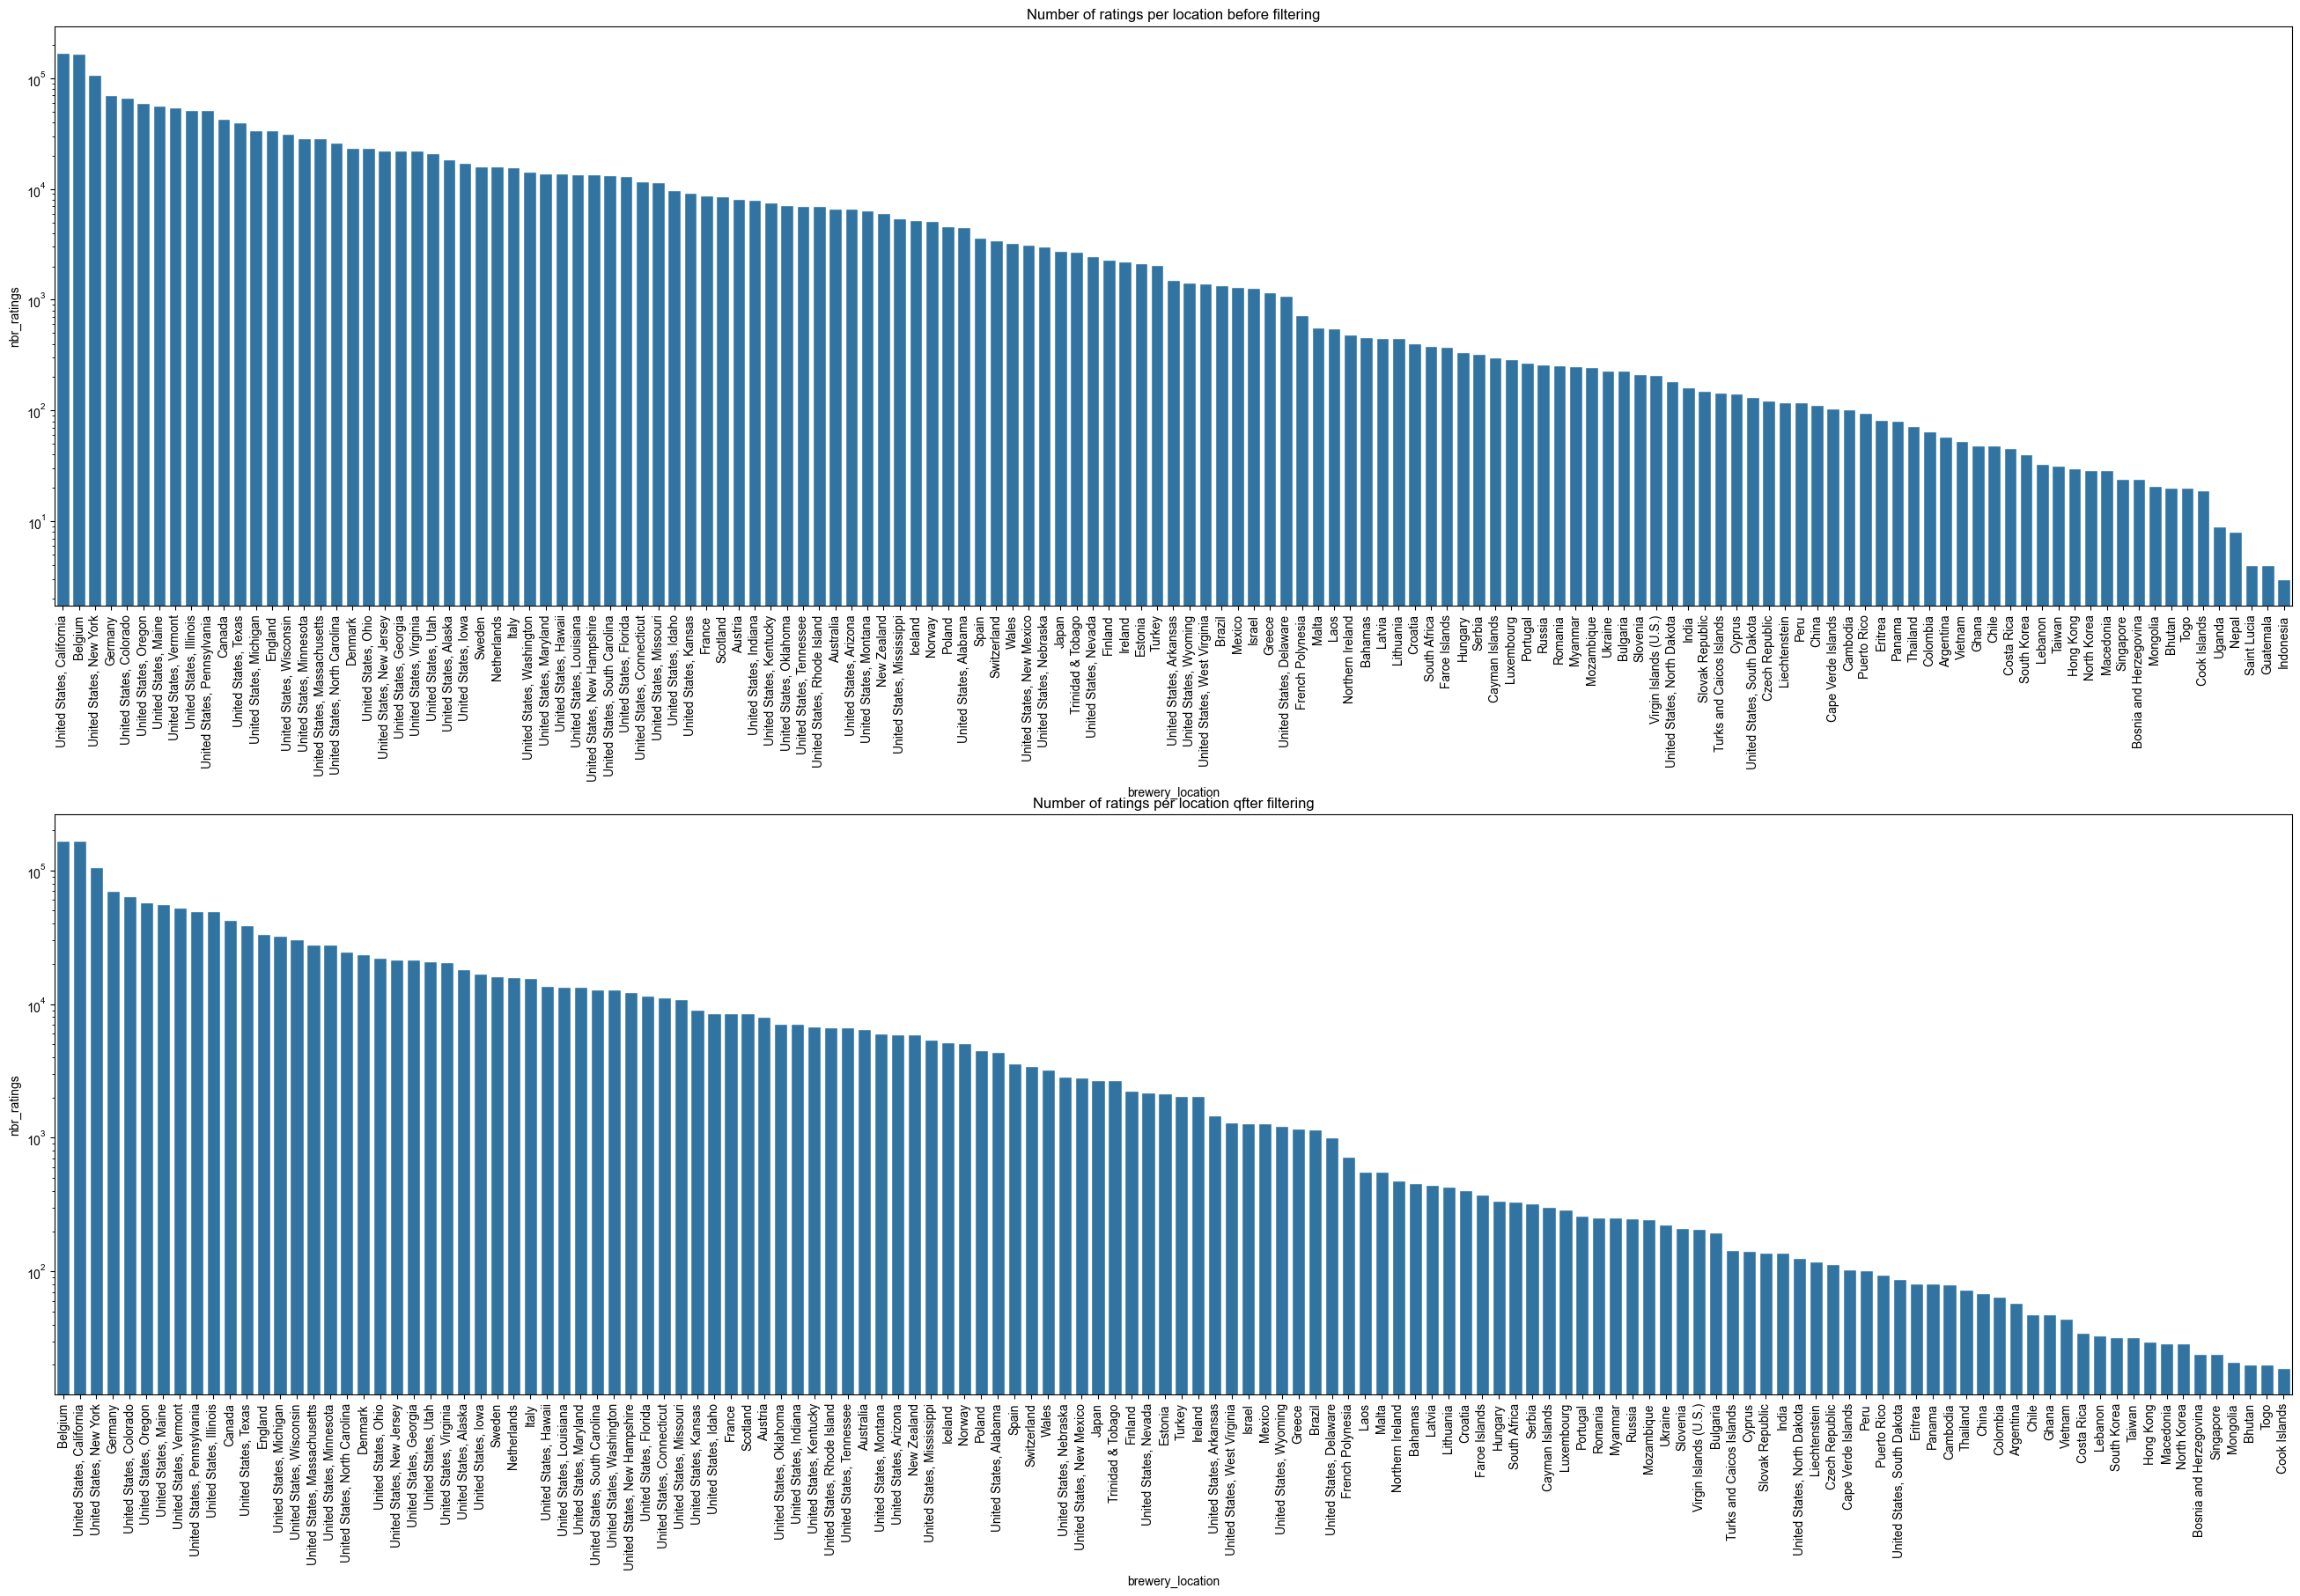

In [6]:
pd.set_option("display.max_columns", None)

world_ratings = reviews_df.copy()
world_ratings["nbr_ratings"] = world_ratings["nbr_ratings_rb"] + world_ratings["nbr_ratings_ba"]
#drop rows where user_location is NaN   
world_ratings = world_ratings.dropna()

#create df with only users from the us & remove duplicates
us_users_ratings = world_ratings[world_ratings["user_location"].str.contains("United States")]
us_users_ratings = us_users_ratings.T.drop_duplicates().T

#convert ratings from string to float
columns_compare = ["aroma", "appearance", "palate", "taste", "overall", "rating"]
us_users_ratings[columns_compare] = us_users_ratings[columns_compare].astype(float)

us_users_ratings["user_location"] = [name.replace("United States, ", "") for name in us_users_ratings["user_location"]]

#add climate column where climate is the climate of the state the user is from
us_users_ratings["climate"] = us_users_ratings["user_location"].map(states_climate["Climate"])

unique_beers = us_users_ratings[["beer_id", "nbr_ratings", "brewery_location"]].copy().drop_duplicates()
total_ratings = unique_beers["nbr_ratings"].sum()

unique_beers = unique_beers.groupby("brewery_location")["nbr_ratings"].sum().sort_values(ascending=False).reset_index()

fig, axs = plt.subplots(2,1,figsize=(30, 20))
fig.tight_layout(pad = 15.0)
sns.set(rc={"figure.figsize":(30, 10)})
sns.barplot(x="brewery_location", y="nbr_ratings", data=unique_beers, orient="v", ax=axs[0])
axs[0].tick_params(axis="x", rotation=90)
axs[0].set_title("Number of ratings per location before filtering")
axs[0].set(yscale="log")

#only keep beers with more than 10 ratings
us_users_ratings = us_users_ratings[us_users_ratings["nbr_ratings"] > 10]

beers_left = us_users_ratings[["beer_id","nbr_ratings", "brewery_location"]].copy().drop_duplicates()

beers_left = beers_left.groupby("brewery_location")["nbr_ratings"].sum().sort_values(ascending=False).reset_index()

ratings_left = beers_left["nbr_ratings"].sum()
print(" Percentage of ratings left: ", ratings_left / total_ratings * 100, "%")

beers_left["Percentage of ratings"] = beers_left["nbr_ratings"] / beers_left["nbr_ratings"].sum() * 100

sns.set(rc={"figure.figsize":(30, 10)})
sns.barplot(x="brewery_location", y="nbr_ratings", data=beers_left, orient="v", ax=axs[1])
axs[1].set_title("Number of ratings per location qfter filtering")
axs[1].tick_params(axis="x", rotation=90)
plt.yscale("log")

### Textual reviews

/var/folders/0g/yd41q8010pn2lvl2qx960v240000gn/T/ipykernel_64168/1065516929.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_users_txt["user_location"] = [name.replace("United States, ", "") for name in us_users_txt["user_location"]]


 Percentage of ratings left:  81.22244732746941 %


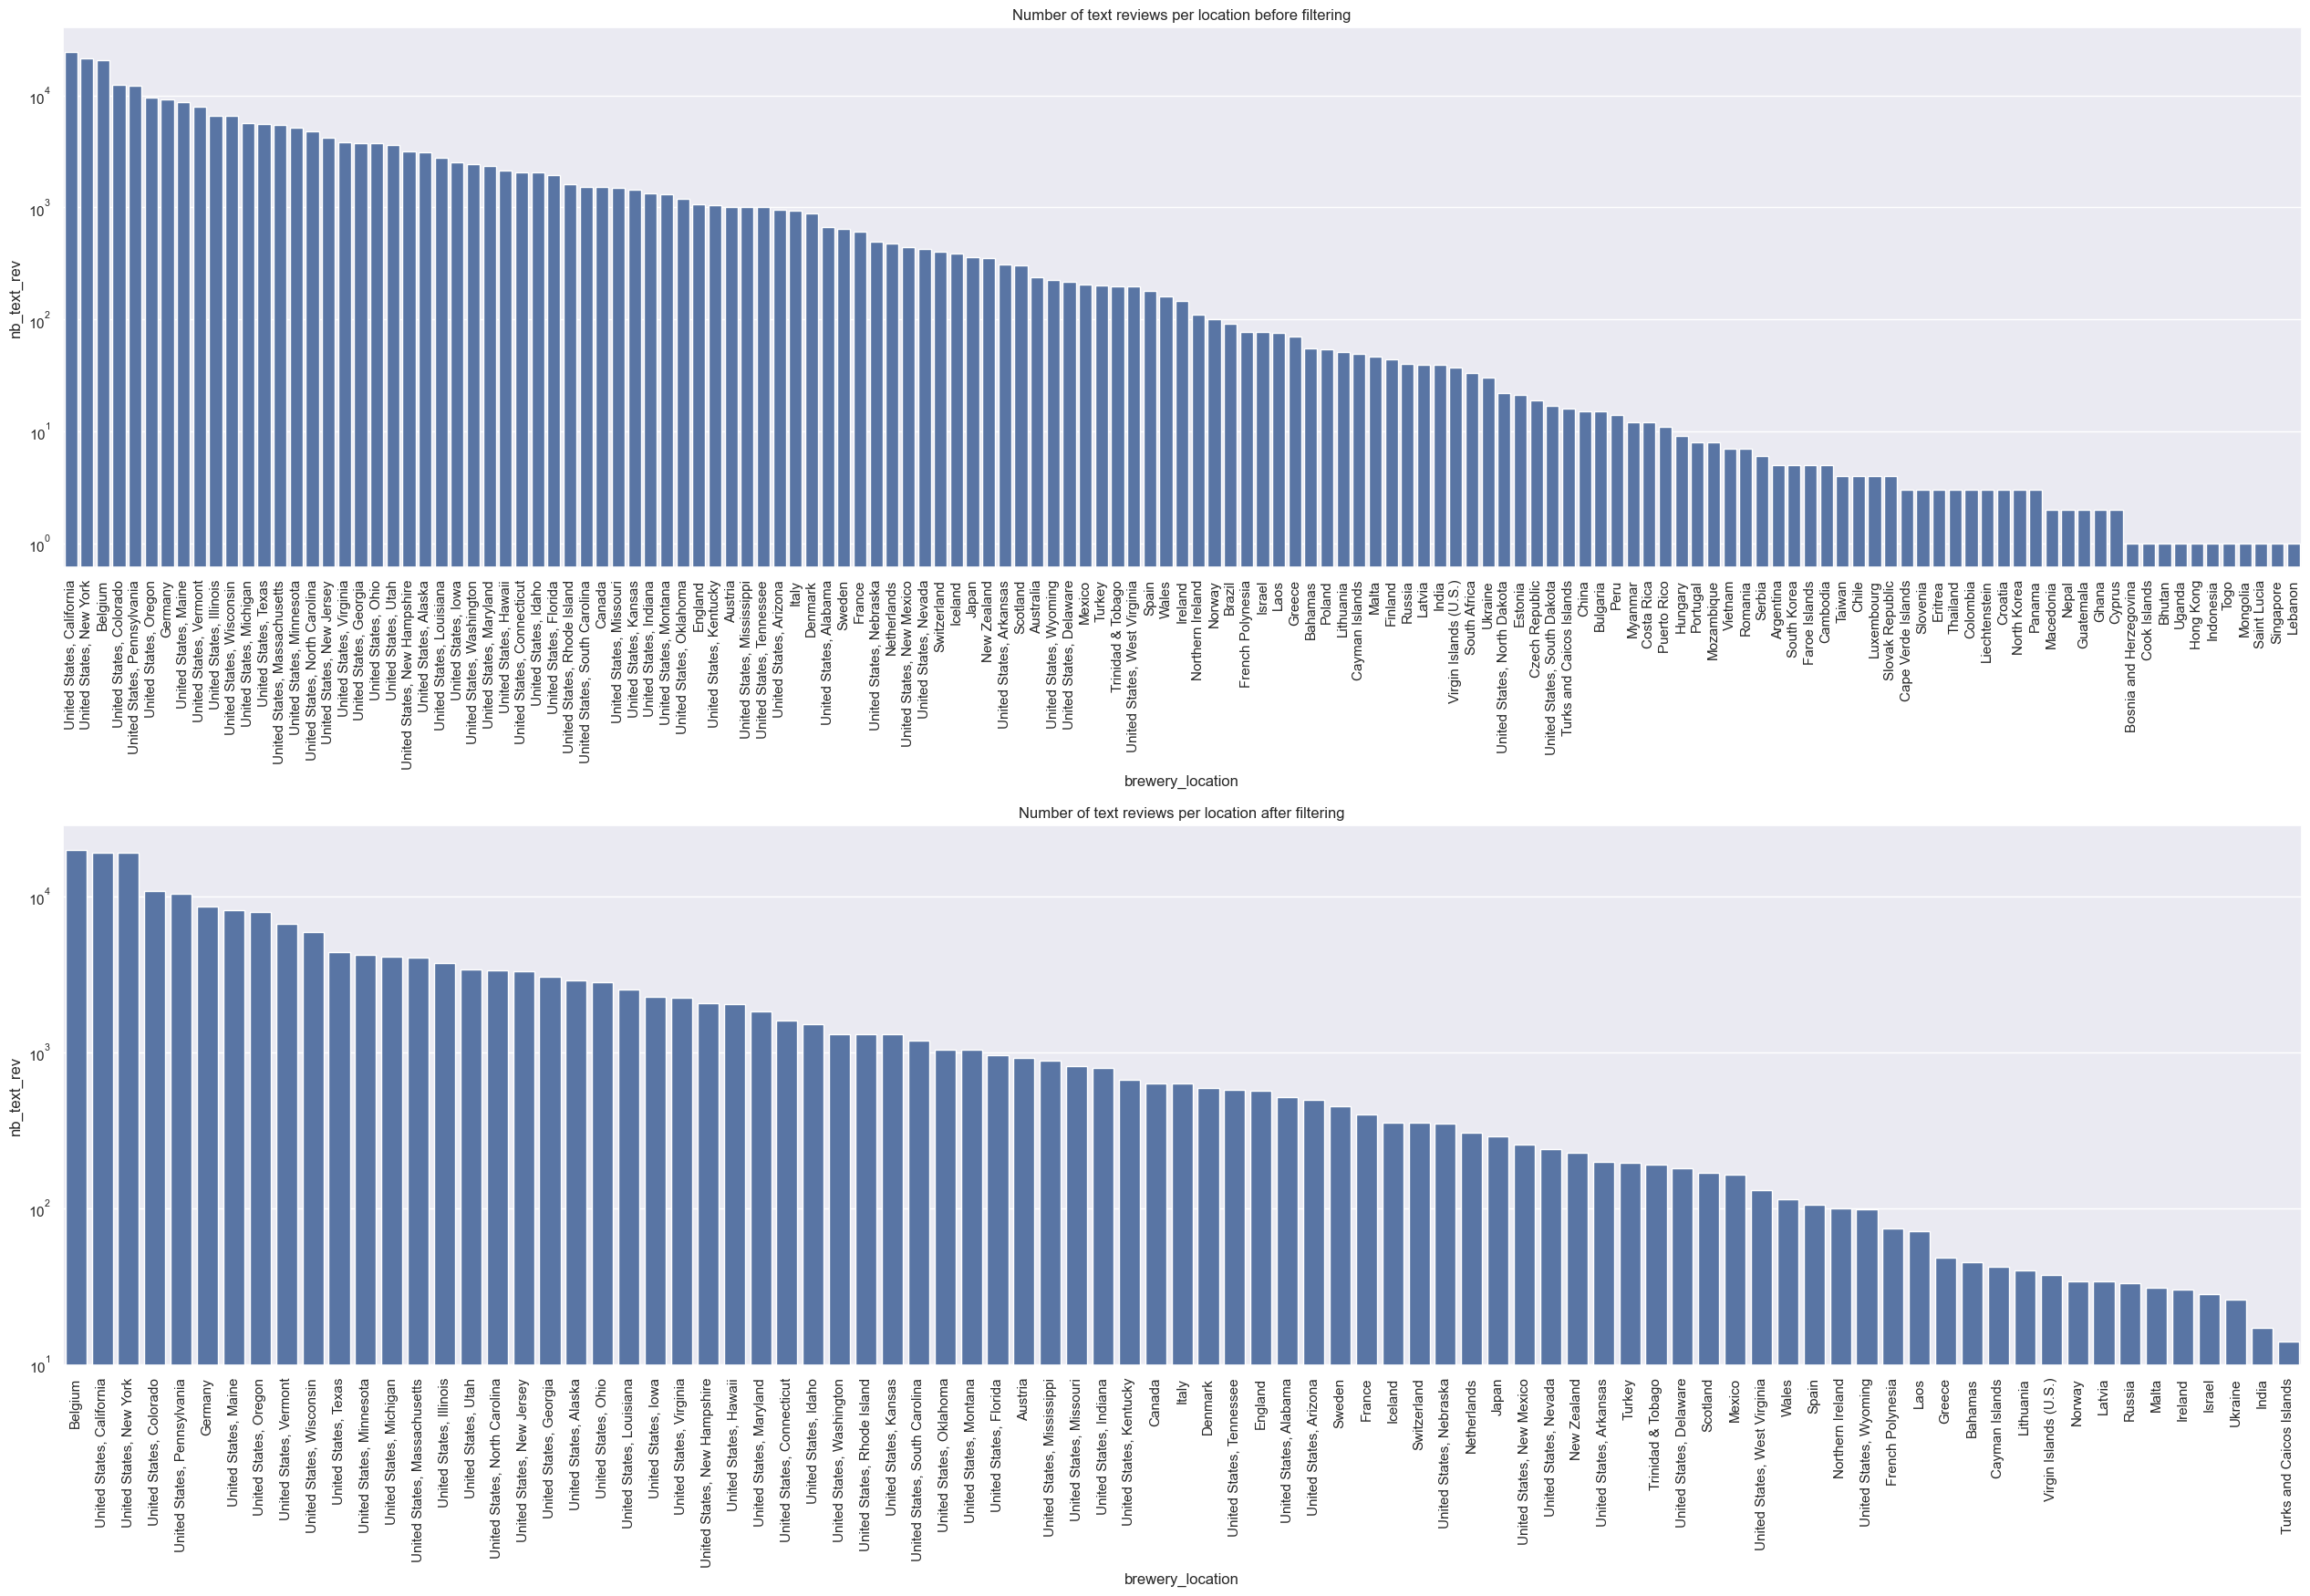

In [7]:
world_ratings = reviews_df.copy()
#drop rows where user_location is NaN   ?
world_ratings = world_ratings.dropna()

#create df with only users from the us
us_users_txt = world_ratings[world_ratings["user_location"].str.contains("United States")]

us_users_txt["user_location"] = [name.replace("United States, ", "") for name in us_users_txt["user_location"]]

#only reviews with text review
us_users_txt = us_users_txt[us_users_txt["text"]!="nan"]

#add climate column where climate is the climate of the state the user is from
us_users_txt["climate"] = us_users_txt["user_location"].map(states_climate["Climate"])

#count number of text reviews per beer

us_users_txt["nb_text_rev"] = us_users_txt.groupby("beer_id")["text"].transform("count")


unique_beers_txt = us_users_txt[["beer_id", "nb_text_rev", "brewery_location"]].copy().drop_duplicates()
total_ratings_txt = unique_beers_txt["nb_text_rev"].sum()

unique_beers_txt = unique_beers_txt.groupby("brewery_location")["nb_text_rev"].sum().sort_values(ascending=False).reset_index()

fig, axs = plt.subplots(2,1,figsize=(30, 20))
fig.tight_layout(pad = 15.0)
sns.set(rc={"figure.figsize":(30, 10)})
sns.barplot(x="brewery_location", y="nb_text_rev", data=unique_beers_txt, orient="v", ax=axs[0])
axs[0].tick_params(axis="x", rotation=90)
axs[0].set_title("Number of text reviews per location before filtering")
axs[0].set(yscale="log")

#only keep beers with more than 10 ratings
us_users_txt = us_users_txt[us_users_txt["nb_text_rev"] > 10]

beers_left_txt = us_users_txt[["beer_id","nb_text_rev", "brewery_location"]].copy().drop_duplicates()

beers_left_txt = beers_left_txt.groupby("brewery_location")["nb_text_rev"].sum().sort_values(ascending=False).reset_index()

ratings_left_txt = beers_left_txt["nb_text_rev"].sum()
print(" Percentage of ratings left: ", ratings_left_txt / total_ratings_txt * 100, "%")

beers_left_txt["Percentage of ratings"] = beers_left_txt["nb_text_rev"] / beers_left_txt["nb_text_rev"].sum() * 100

sns.set(rc={"figure.figsize":(30, 10)})
sns.barplot(x="brewery_location", y="nb_text_rev", data=beers_left_txt, orient="v", ax=axs[1])
axs[1].set_title("Number of text reviews per location after filtering")
axs[1].tick_params(axis="x", rotation=90)
plt.yscale("log")


In [66]:
def plot_climate_stats(df, column, title, ax=None, symmetrical=False, categorical=False):
    """
    This function plots on a map of the United States the mean of the column passed as argument for each state depending on its climate.
    df should have a column "climate" and a column str(column) with the values to plot. Requires to call plt.show() after the function call.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data to plot
        column (str): Column to plot
        title (str): Title of the plot
        ax (matplotlib.axes.Axes, optional): Axes on which to plot. If None, a new figure and axes is created.
        symmetrical (bool, optional): If True, the colorbar is symmetrical around 0. If False, the colorbar is not symmetrical around 0.
        categorical (bool, optional): If True, the column is categorical. If False, the column is numerical.
    """
    
    us_map = gpd.read_file("data/Maps/US/cb_2018_us_state_500k.shp")
    states_climate = pd.read_csv("data/states_climate.csv")

    # Add climate column to us_map and the df
    us_map = us_map.merge(states_climate, left_on="NAME", right_on="State")
    
    us_map = us_map.merge(df, left_on="Climate", right_on="climate")
    
    # For display purposes, move Alaska and Hawaii to the East
    alaska = us_map[us_map["NAME"] == "Alaska"].geometry
    hawaii = us_map[us_map["NAME"] == "Hawaii"].geometry

    alaska = alaska.translate(xoff=40)
    hawaii = hawaii.translate(xoff=40)

    us_map_shifted = us_map.copy()
    us_map_shifted.loc[us_map_shifted["NAME"] == "Alaska", "geometry"] = alaska
    us_map_shifted.loc[us_map_shifted["NAME"] == "Hawaii", "geometry"] = hawaii
    
    # Plot the map
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,7))
    us_map_shifted.boundary.plot(ax=ax, linewidth=1, color="black")
    
    if symmetrical:
        cmap_name = "RdBu_r"
    elif categorical:
        cmap_name = "tab10"
    else:
        cmap_name = "YlOrRd"
        
    
    us_map_shifted.plot(column=column, cmap=cmap_name, ax=ax, legend=True, missing_kwds={"color": "lightgrey", "label": "Missing values"})
    ax.set_title(title)
    ax.set_axis_off()
    ax.set_xlim(-140, -60)

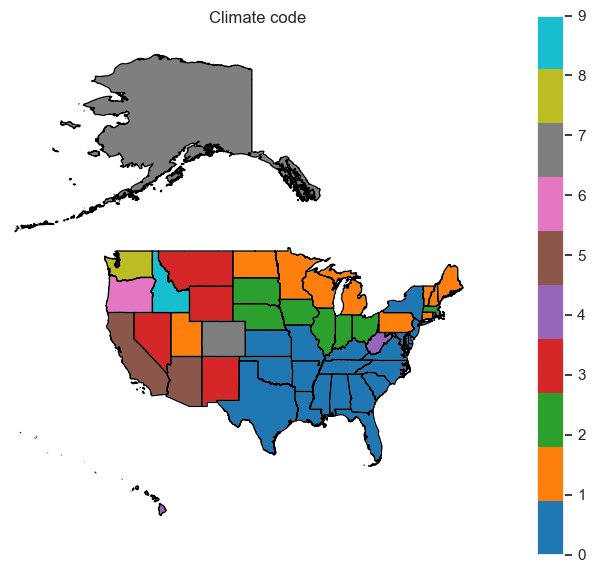

In [69]:
climate_df = pd.DataFrame(columns=["climate", "climate_code"])
climate_df["climate"] = states_climate["Climate"].unique()
climate_df["climate_code"] = range(len(climate_df))

plot_climate_stats(climate_df, "climate_code", "Climate code", categorical=True)

## 2) First analysis : how beers from one country are rated (reviewed)

We first want to look at how beers from a given country are perceived by users. We start from the full dataframe with all the reviews.

### Data cleaning

Let's first look at distribution of number of reviews

In [9]:
micro_average_ratings = us_users_ratings[columns_compare].mean().sort_values(ascending=False).reset_index()

display(micro_average_ratings)

# Let's compute statistics for each climate
climate_average_ratings = us_users_ratings.groupby("climate")[columns_compare].mean().sort_values(by="overall", ascending=False).reset_index()
climate_average_ratings.set_index("climate", inplace=True)
macro_average_ratings = climate_average_ratings.mean().sort_values(ascending=False).reset_index()

display(macro_average_ratings)

,index,0
0,appearance,3.930901
1,overall,3.890745
2,taste,3.884031
3,rating,3.878382
4,palate,3.853295
5,aroma,3.851912


,index,0
0,appearance,3.905448
1,overall,3.854648
2,taste,3.848610
3,rating,3.844567
4,aroma,3.821974
5,palate,3.815771


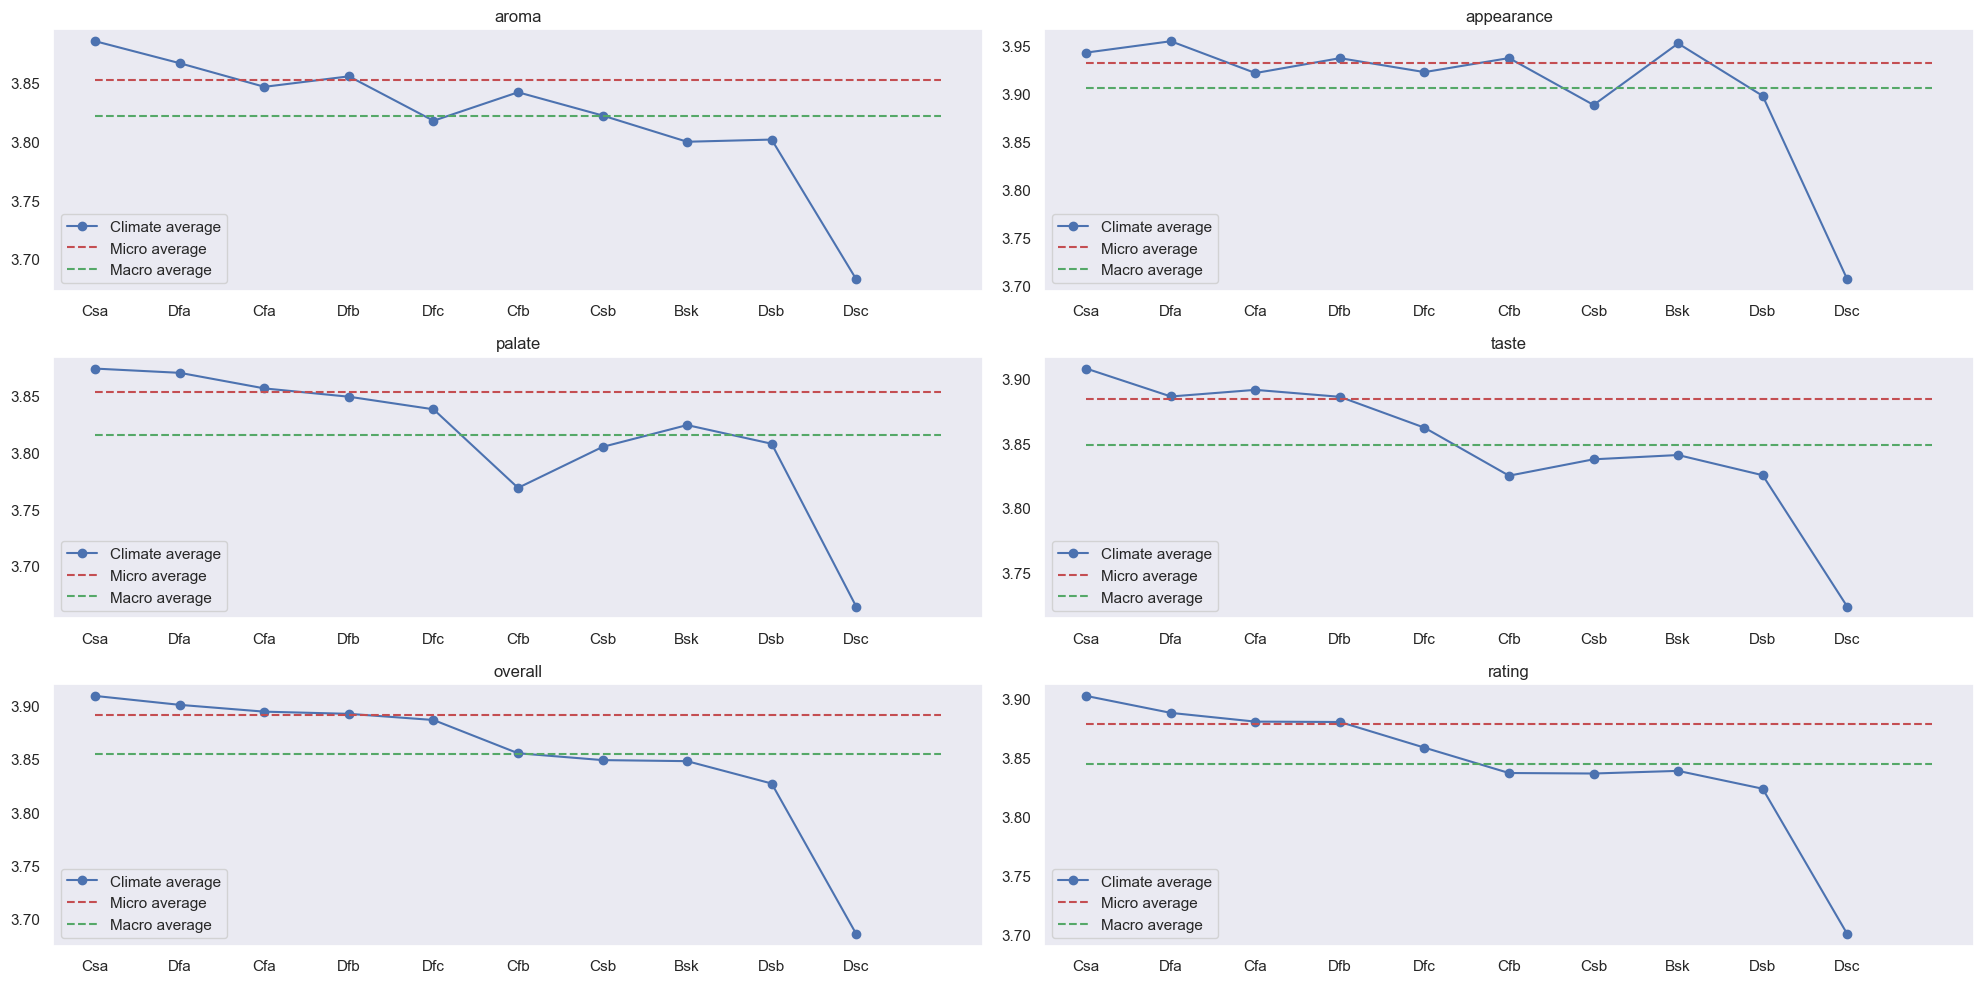

In [10]:
# Plot the different mean as a function of the climate
num_scores = len(columns_compare)

fig, axs = plt.subplots(num_scores//2, 2, figsize=(20, 10))

for i in range(num_scores//2):
    axs[i, 0].plot(climate_average_ratings.iloc[:, 2*i], "o-", label="Climate average")
    micro_average_value = micro_average_ratings[micro_average_ratings["index"] == columns_compare[2*i]][0].values[0]
    macro_average_value = macro_average_ratings[macro_average_ratings["index"] == columns_compare[2*i]][0].values[0]
    axs[i, 0].plot([0, len(climate_average_ratings)], [micro_average_value, micro_average_value], "r--", label="Micro average")
    axs[i, 0].plot([0, len(climate_average_ratings)], [macro_average_value, macro_average_value], "g--", label="Macro average")
    axs[i, 0].set_title(columns_compare[2*i])
    axs[i, 0].set_xticks(range(len(climate_average_ratings)))
    axs[i, 0].legend()
    axs[i, 0].grid()

    axs[i, 1].plot(climate_average_ratings.iloc[:, 2*i+1], "o-", label="Climate average")
    micro_average_value = micro_average_ratings[micro_average_ratings["index"] == columns_compare[2*i+1]][0].values[0]
    macro_average_value = macro_average_ratings[macro_average_ratings["index"] == columns_compare[2*i+1]][0].values[0]
    axs[i, 1].plot([0, len(climate_average_ratings)], [micro_average_value, micro_average_value], "r--", label="Micro average")
    axs[i, 1].plot([0, len(climate_average_ratings)], [macro_average_value, macro_average_value], "g--", label="Macro average")
    axs[i, 1].set_title(columns_compare[2*i+1])
    axs[i, 1].set_xticks(range(len(climate_average_ratings)))
    axs[i, 1].legend()
    axs[i, 1].grid()

plt.tight_layout()
plt.show()

In [11]:
# For each climate, compute a p-value for difference between the mean and the mean of the whole dataset
from scipy.stats import ttest_ind

ratings_p_values = pd.DataFrame(columns=["climate", "aroma", "appearance", "palate", "taste", "overall"])
ratings_p_values["climate"] = climate_average_ratings.index
for climate in ratings_p_values["climate"]:
    current_climate_df = us_users_ratings[us_users_ratings["climate"] == climate]
    
    for column in columns_compare:
        p_value = ttest_ind(current_climate_df[column], us_users_ratings[column])[1]
        
        ratings_p_values.loc[ratings_p_values["climate"] == climate, column] = 0 if p_value > 0.05 else 1
    
ratings_p_values.set_index("climate", inplace=True)

display(ratings_p_values)

,aroma,appearance,palate,taste,overall,rating
climate,,,,,,
Csa,1,1,1,1,1,1.0
Dfa,1,1,1,0,1,1.0
Cfa,1,1,0,1,0,0.0
Dfb,0,1,0,0,0,0.0
Dfc,1,0,1,1,0,1.0
Cfb,0,0,1,1,0,1.0
Csb,1,1,1,1,1,1.0
Bsk,1,0,1,1,1,1.0
Dsb,1,1,1,1,1,1.0


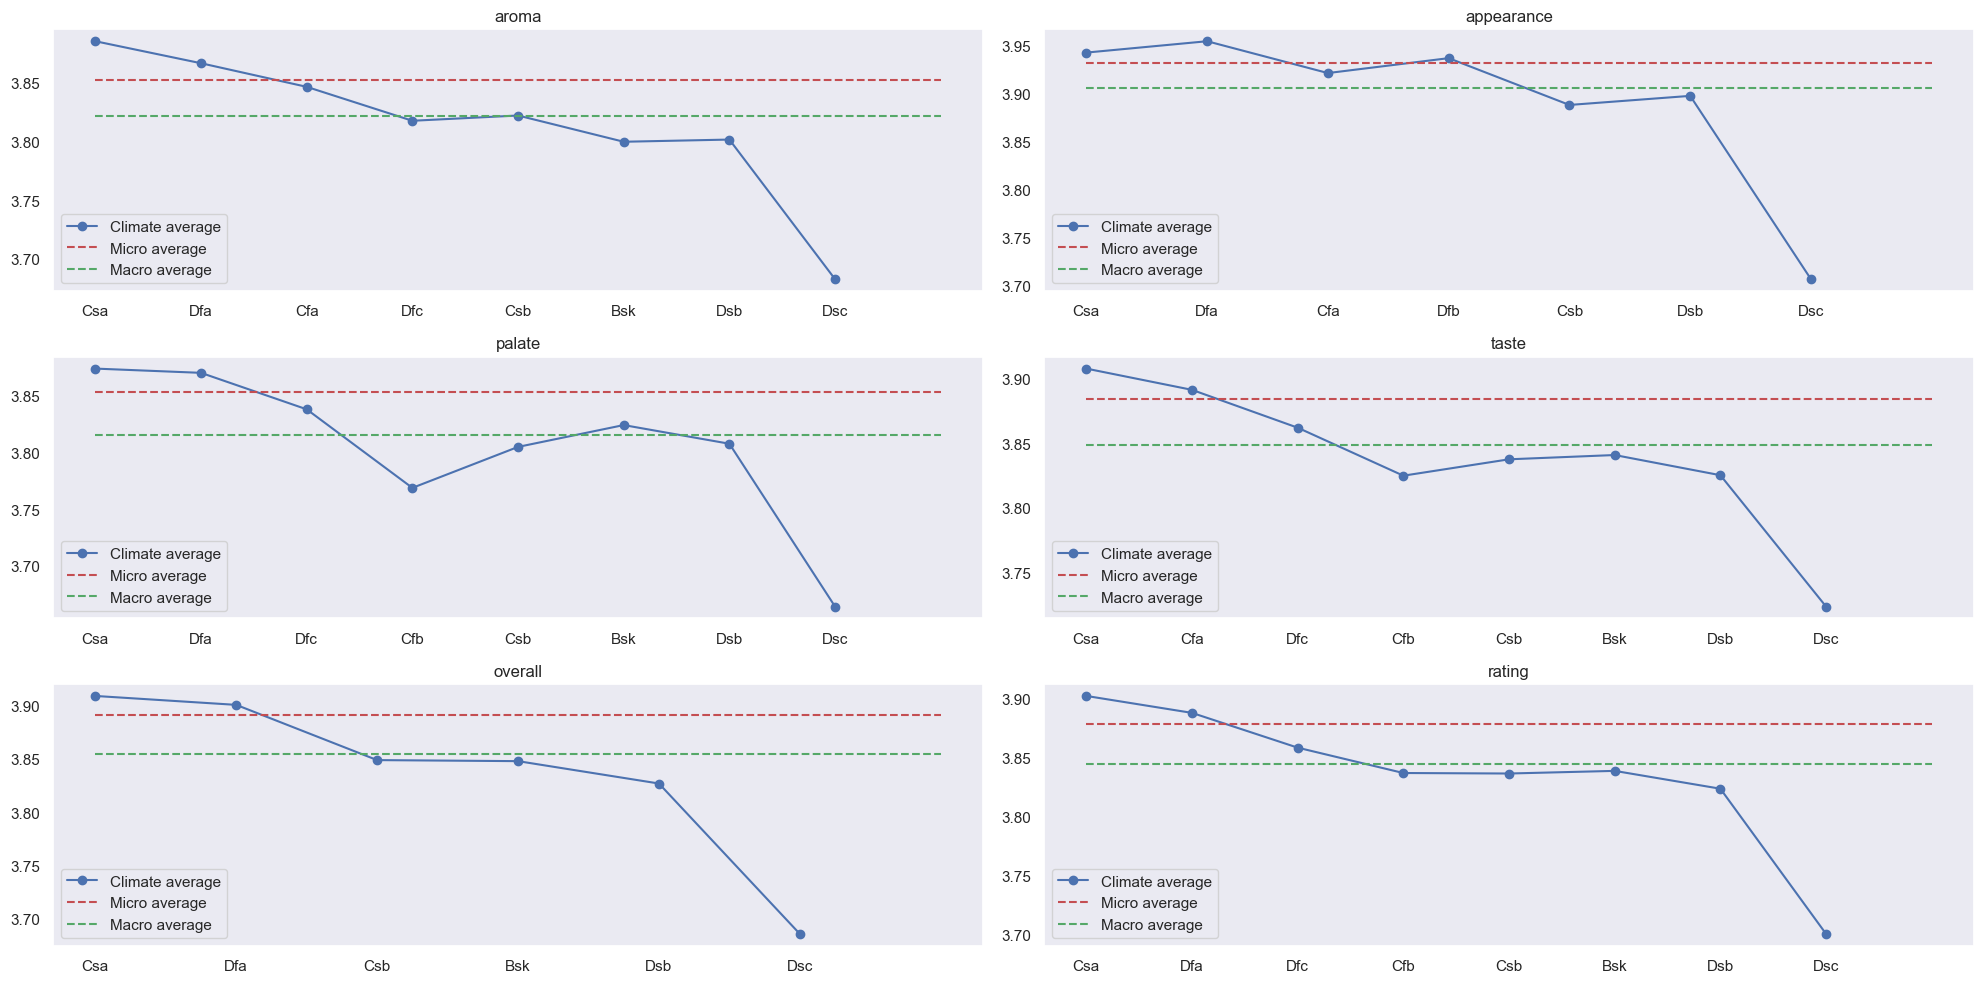

In [12]:
# Let's redo the previous plot but for each score keep only the climate where the p-value is significant
num_scores = len(columns_compare)

fig, axs = plt.subplots(num_scores//2, 2, figsize=(20, 10))

for i in range(num_scores//2):
    to_plot = climate_average_ratings[ratings_p_values[columns_compare[2*i]] == 1]
    axs[i, 0].plot(to_plot.iloc[:, 2*i], "o-", label="Climate average")
    average_value = micro_average_ratings[micro_average_ratings["index"] == columns_compare[2*i]][0].values[0]
    axs[i, 0].plot([0, len(to_plot)], [average_value, average_value], "r--", label="Micro average")
    macro_average_value = macro_average_ratings[macro_average_ratings["index"] == columns_compare[2*i]][0].values[0]
    axs[i, 0].plot([0, len(to_plot)], [macro_average_value, macro_average_value], "g--", label="Macro average")
    axs[i, 0].set_title(columns_compare[2*i])
    axs[i, 0].set_xticks(range(len(to_plot)))
    axs[i, 0].legend()
    axs[i, 0].grid()
    
    to_plot = climate_average_ratings[ratings_p_values[columns_compare[2*i+1]] == 1]
    axs[i, 1].plot(to_plot.iloc[:, 2*i+1], "o-", label="Climate average")
    average_value = micro_average_ratings[micro_average_ratings["index"] == columns_compare[2*i+1]][0].values[0]
    axs[i, 1].plot([0, len(to_plot)], [average_value, average_value], "r--", label="Micro average")
    macro_average_value = macro_average_ratings[macro_average_ratings["index"] == columns_compare[2*i+1]][0].values[0]
    axs[i, 1].plot([0, len(to_plot)], [macro_average_value, macro_average_value], "g--", label="Macro average")
    axs[i, 1].set_title(columns_compare[2*i+1])
    axs[i, 1].set_xticks(range(len(to_plot)))
    axs[i, 1].legend()
    axs[i, 1].grid()

plt.tight_layout()
plt.show()

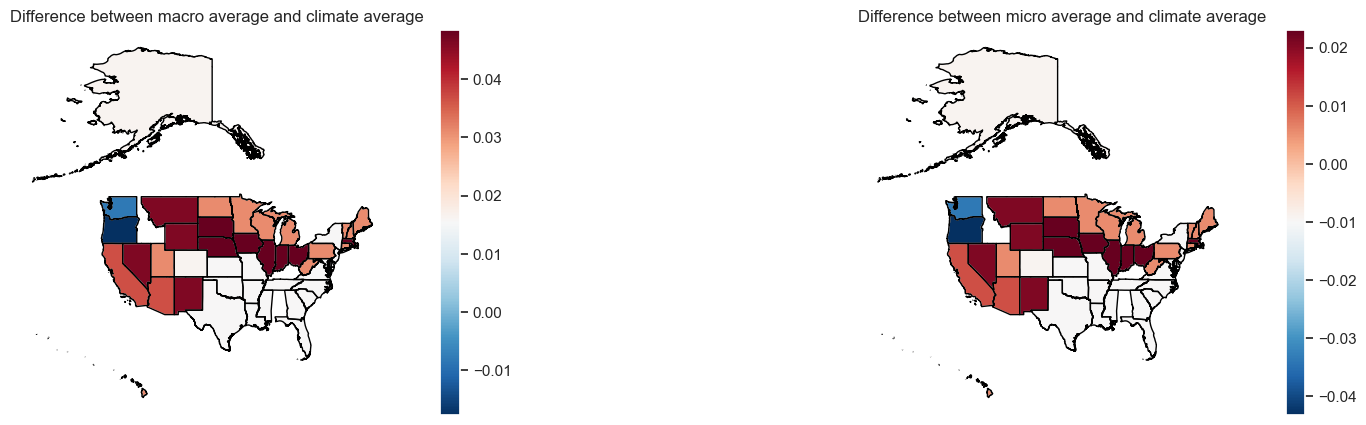

In [13]:
climate_appearance = climate_average_ratings["appearance"].reset_index()

# Drop Dsc climate for testing as it seems like a big outlier
climate_appearance = climate_appearance[climate_appearance["climate"] != "Dsc"]

climate_appearance["diff_macro"] = climate_appearance["appearance"] - macro_average_ratings[macro_average_ratings["index"] == "appearance"][0].values[0]
climate_appearance["diff_micro"] = climate_appearance["appearance"] - micro_average_ratings[micro_average_ratings["index"] == "appearance"][0].values[0]

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

plot_climate_stats(climate_appearance, "diff_macro", "Difference between macro average and climate average", ax=axs[0], symmetrical=True)
plot_climate_stats(climate_appearance, "diff_micro", "Difference between micro average and climate average", ax=axs[1], symmetrical=True)

plt.show()

Let's go in more in-depth analysis of the climate distribution

In [14]:
# First we can print the number of reviews per climate
print("Number of reviews per climate:")
display(us_users_ratings["climate"].value_counts())

Number of reviews per climate:


climate
Cfa    81212
Dfb    50644
Dfa    44947
Csa    22066
Dsb     8202
Dfc     7704
Csb     4708
Bsk     2150
Cfb     1148
Dsc     1008
Name: count, dtype: int64

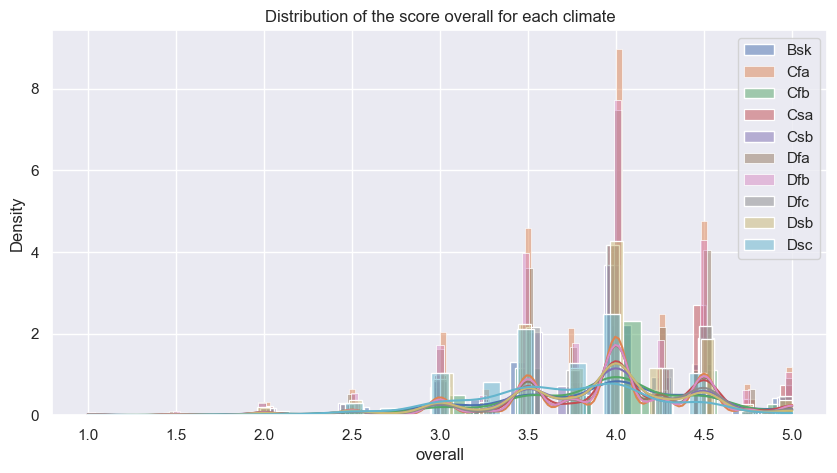

In [25]:
# For one chosen score, plot the distribution of the score for each climate
score = "overall"

# Get the data
data_to_plot = us_users_ratings[["climate", score]].copy()
data_to_plot = data_to_plot.groupby("climate")[score].apply(list).reset_index()

# Plot the data
box_plot = False
if box_plot:
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.boxplot(data_to_plot[score])
    ax.set_xticklabels(data_to_plot["climate"])
    ax.set_ylabel(score)
    ax.set_title("Distribution of the score " + score + " for each climate")
else:
    # Use superimposed histograms
    fig, ax = plt.subplots(figsize=(10, 5))
    for i in range(len(data_to_plot)):
        sns.histplot(data_to_plot[score][i], ax=ax, label=data_to_plot["climate"][i], kde=True, stat="density")
    ax.set_xlabel(score)
    ax.set_ylabel("Density")
    ax.set_title("Distribution of the score " + score + " for each climate")
    ax.legend()
    
    
plt.show()

In [51]:
# Perform a chi2 test to see if the distribution of the score is the same for each climate
from scipy.stats import chi2_contingency

score = "appearance"

# Get the data
data_to_plot = us_users_ratings[["climate", score]].copy()
data_to_plot = data_to_plot.groupby("climate")[score].apply(list).reset_index()

num_reviews_min = data_to_plot[score].apply(len).min()

data_chi2 = np.zeros((len(data_to_plot), num_reviews_min))
for i in range(len(data_to_plot)):
    # For each climate, randomly select num_reviews_min reviews
    data_chi2[i] = np.random.choice(data_to_plot[score][i], num_reviews_min, replace=False)
    
# Perform the chi2 test
chi2, p, dof, expected = chi2_contingency(data_chi2)
print("Chi2 test for the score", score)
print("p-value:", p)
if p < 0.05:
    print("The distribution of the score is not the same for each climate")
else:
    print("The distribution of the score is the same for each climate")

Chi2 test for the score appearance
p-value: 1.0
The distribution of the score is the same for each climate


In [60]:
# Let's test to have some models which can predict the score of a beer based on its climate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create dataframe with the score to guess and a one-hot encoding of the climate
score = "overall"
data_to_plot = us_users_ratings[["climate", score]].copy()
data_to_plot["climate"] = pd.Categorical(data_to_plot["climate"])
data_to_plot = pd.get_dummies(data_to_plot, columns=["climate"])
data_to_plot[data_to_plot.columns[1:]] = data_to_plot[data_to_plot.columns[1:]].astype(int)

display(data_to_plot)

,overall,climate_Bsk,climate_Cfa,climate_Cfb,climate_Csa,climate_Csb,climate_Dfa,climate_Dfb,climate_Dfc,climate_Dsb,climate_Dsc
7,3.75,0,1,0,0,0,0,0,0,0,0
8,3.75,0,1,0,0,0,0,0,0,0,0
12,2.50,0,0,0,0,0,1,0,0,0,0
14,4.00,0,0,0,0,0,1,0,0,0,0
16,2.50,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
955947,2.00,0,0,0,1,0,0,0,0,0,0
955953,3.50,0,0,0,1,0,0,0,0,0,0
955962,4.00,0,0,1,0,0,0,0,0,0,0
955963,3.50,0,0,0,1,0,0,0,0,0,0


## 3) Text reviews baseline

Compute the average sentiment analysis score for us users and then average per state

In [11]:
saved = True

def get_lang_detector(nlp, name):
    return LanguageDetector(seed=42)  # We use the seed 42

#load spacy model and add pipeline to detect language
nlp_model = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp_model.add_pipe('language_detector', last=True)
nlp_model.add_pipe('spacytextblob')

if saved :
    print("retreiving language of text reviews from csv")
    us_users_txt = pd.read_csv("data/us_users_txt.csv")
else :
    #detect language of text reviews
    us_users_txt["language"] = us_users_txt["text"].apply(lambda x: nlp_model(x)._.language["language"])
    us_users_txt["polarity"] = us_users_txt["text"].apply(lambda x: nlp_model(x)._.blob.polarity)
    us_users_txt["subjectivity"] = us_users_txt["text"].apply(lambda x: nlp_model(x)._.blob.subjectivity)
    us_users_txt.to_csv("data/us_users_txt.csv")

ValueError: [E002] Can't find factory for 'spacytextblob' for language English (en). This usually happens when spaCy calls `nlp.create_pipe` with a custom component name that's not registered on the current language class. If you're using a Transformer, make sure to install 'spacy-transformers'. If you're using a custom component, make sure you've added the decorator `@Language.component` (for function components) or `@Language.factory` (for class components).

Available factories: attribute_ruler, tok2vec, merge_noun_chunks, merge_entities, merge_subtokens, token_splitter, doc_cleaner, parser, beam_parser, lemmatizer, trainable_lemmatizer, entity_linker, ner, beam_ner, entity_ruler, tagger, morphologizer, senter, sentencizer, textcat, spancat, spancat_singlelabel, future_entity_ruler, span_ruler, textcat_multilabel, en.lemmatizer

In [ ]:
doc = us_users_txt["text"].iloc[0:4]
#detect language of text reviews and see how much time it takes
import time
start_time = time.time()
doc = doc.apply(lambda x: nlp_model(x)._.blob.polarity)
duration = (time.time() - start_time)
print("--- %s seconds ---" % duration)

print(len(us_users_txt["text"]), "duration ", len(us_users_txt["text"])/4/60/60, "heures")
print(doc)

In [ ]:
#compute sentiment analysis of text reviews